In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns;
sns.set_style('darkgrid')
from collections import Counter

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.simplefilter('ignore')


#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:95% !important; }</style>"))

# Modeling
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [5]:
!pwd

/home/jhon/Documents/Personal_Plan/Project_3_ChurnRatePrediction/projectChurnRate


# 1. Dataset 
Dataset source: https://github.com/Paritoshyadav/Minimizing-Churn-Rate-Through-Analysis-of-Financial-Habits



## Dataset:

In [4]:
# Loading the data

dfChurnBank = pd.read_csv('../projectChurnRate/Data/churn_data.csv', index_col=0)

print("Size of the dataset:  %d" % dfChurnBank.shape[0])
print("Number of variables: %d" % dfChurnBank.shape[1])

if dfChurnBank.index.is_unique:
    print('Indexes are unique.')
else:
    print('There are duplicated indexes.')
    
dfChurnBank.head()

Size of the dataset:  27000
Number of variables: 30
There are duplicated indexes.


,churn,age,housing,credit_score,deposits,withdrawal,purchases_partners,purchases,cc_taken,cc_recommended,...,waiting_4_loan,cancelled_loan,received_loan,rejected_loan,zodiac_sign,left_for_two_month_plus,left_for_one_month,rewards_earned,reward_rate,is_referred
user,,,,,,,,,,,,,,,,,,,,,
55409,0,37.0,na,NaN,0,0,0,0,0,0,...,0,0,0,0,Leo,1,0,NaN,0.00,0
23547,0,28.0,R,486.0,0,0,1,0,0,96,...,0,0,0,0,Leo,0,0,44.0,1.47,1
58313,0,35.0,R,561.0,47,2,86,47,0,285,...,0,0,0,0,Capricorn,1,0,65.0,2.17,0
8095,0,26.0,R,567.0,26,3,38,25,0,74,...,0,0,0,0,Capricorn,0,0,33.0,1.10,1
61353,1,27.0,na,NaN,0,0,2,0,0,0,...,0,0,0,0,Aries,1,0,1.0,0.03,0


In [7]:
# Split dataset for modeling and predicting

trainLen = int(len(dfChurnBank)*0.8)
dfChurnBank = dfChurnBank.sample(frac=1, random_state=0)
df = dfChurnBank.iloc[:trainLen].copy()
df_pred = dfChurnBank.iloc[trainLen:].copy()
print('Size of dataset for modeling is {}'.format(len(df)))
print('Size of dataset for prediction is {}'.format(len(df_pred)))

Size of dataset for modeling is 21600
Size of dataset for prediction is 5400


# 3. Pre-processing

1. Remove Null/Nan values
2. Remove duplicated indexes
3. Remove not useful features: app_web_user, deposit, ios_user, cc_recommended, cancelled_loan', 'received_loan', 'rejected_loan', 'waiting_4_loan' columns
4. Update numerical and categorical values list for modeling
5. Remove outliers
6. Create pre-process pipeline function for next preprocesing for test data.


In [8]:
print("Size of the dataset:  %d" % df.shape[0])
print("Number of variables: %d" % df.shape[1])
df.head()

Size of the dataset:  21600
Number of variables: 30


,churn,age,housing,credit_score,deposits,withdrawal,purchases_partners,purchases,cc_taken,cc_recommended,...,waiting_4_loan,cancelled_loan,received_loan,rejected_loan,zodiac_sign,left_for_two_month_plus,left_for_one_month,rewards_earned,reward_rate,is_referred
user,,,,,,,,,,,,,,,,,,,,,
59394,1,21.0,na,NaN,0,0,0,0,0,0,...,0,0,0,0,Aquarius,0,0,NaN,0.00,0
50931,1,28.0,na,449.0,0,0,0,0,0,129,...,0,0,0,0,Aquarius,0,0,31.0,1.03,0
28738,0,27.0,R,513.0,58,8,65,58,0,294,...,0,0,0,0,Scorpio,0,1,66.0,2.20,1
55968,0,44.0,na,551.0,0,0,0,0,0,0,...,0,0,0,0,Aquarius,0,0,NaN,0.00,0
50686,1,39.0,O,510.0,0,0,0,0,0,35,...,0,0,0,0,Capricorn,0,0,12.0,0.40,1


We create a pipeline_preprocess list in order to store all pre-process functions in order to apply later to the prediction dataset.

In [9]:
# Pipeline for pre-preocessing
pipeline_preprocess = []


## 1. Remove Null and Nan values

In [10]:
null_finder = df.isnull().sum()
print(" ***** Number of Null Values by row: ***** ")
null_finder.where(null_finder > 0).dropna()

 ***** Number of Null Values by row: ***** 


age                  4.0
credit_score      6446.0
rewards_earned    2588.0
dtype: float64

In [11]:
def dropnull(df):
    print("Removing columns credit_score and rewards_earned ...(1)")
    df = df.drop(columns=['credit_score','rewards_earned'])
    print("Drop null values from age column ...(2)")
    df = df[pd.notnull(df['age'])]
    return df

df = dropnull(df)

null_finder = df.isnull().sum()
print(" ***** Number of Null Values by row: ***** ")
null_finder.where(null_finder > 0).dropna()


Removing columns credit_score and rewards_earned ...(1)
Drop null values from age column ...(2)
 ***** Number of Null Values by row: ***** 


Series([], dtype: float64)

In [12]:
print("Size of the dataset:  %d" % df.shape[0])
print("Number of variables: %d" % df.shape[1])
df.head(10)

Size of the dataset:  21596
Number of variables: 28


,churn,age,housing,deposits,withdrawal,purchases_partners,purchases,cc_taken,cc_recommended,cc_disliked,...,payment_type,waiting_4_loan,cancelled_loan,received_loan,rejected_loan,zodiac_sign,left_for_two_month_plus,left_for_one_month,reward_rate,is_referred
user,,,,,,,,,,,,,,,,,,,,,
59394,1,21.0,na,0,0,0,0,0,0,0,...,Bi-Weekly,0,0,0,0,Aquarius,0,0,0.00,0
50931,1,28.0,na,0,0,0,0,0,129,1,...,Weekly,0,0,0,0,Aquarius,0,0,1.03,0
28738,0,27.0,R,58,8,65,58,0,294,0,...,na,0,0,0,0,Scorpio,0,1,2.20,1
55968,0,44.0,na,0,0,0,0,0,0,0,...,Monthly,0,0,0,0,Aquarius,0,0,0.00,0
50686,1,39.0,O,0,0,0,0,0,35,0,...,Bi-Weekly,0,0,0,0,Capricorn,0,0,0.40,1
36115,1,27.0,na,0,0,0,0,0,0,0,...,Monthly,0,0,0,0,Pisces,1,0,0.00,0
19748,1,30.0,R,0,0,1,0,1,255,0,...,Bi-Weekly,0,0,0,0,Gemini,1,0,1.73,0
46479,0,41.0,O,1,1,19,1,0,49,0,...,Bi-Weekly,0,0,0,0,Scorpio,0,0,0.60,0
15946,0,32.0,R,15,4,213,15,0,283,0,...,Bi-Weekly,0,0,0,0,Cancer,0,0,2.23,0


In [13]:
# Adding to pre-preocessing pipeline:

pipeline_preprocess.append(dropnull)

## 2. Remove duplicated indexes

In [14]:
if df.index.is_unique:
    print('Indexes are unique.')
else:
    print('There are duplicated indexes.')

There are duplicated indexes.


In [15]:
# This function will be agregated to the pre-precessing pipeline:
def dropduplicated(df):
    if df.index.is_unique:
        print('Indexes are unique.')
        return df
    else:
        print('There are duplicated indexes....So removing duplicated indexes ...(3)')
        return df[~df.index.duplicated(keep='first')]

df = dropduplicated(df)


if df.index.is_unique:
    print('Indexes are unique.')
else:
    print('There are duplicated indexes.')

print("Size of the dataset:  %d" % df.shape[0])
print("Number of variables: %d" % df.shape[1])
df.head(10)

There are duplicated indexes....So removing duplicated indexes ...(3)
Indexes are unique.
Size of the dataset:  20105
Number of variables: 28


,churn,age,housing,deposits,withdrawal,purchases_partners,purchases,cc_taken,cc_recommended,cc_disliked,...,payment_type,waiting_4_loan,cancelled_loan,received_loan,rejected_loan,zodiac_sign,left_for_two_month_plus,left_for_one_month,reward_rate,is_referred
user,,,,,,,,,,,,,,,,,,,,,
59394,1,21.0,na,0,0,0,0,0,0,0,...,Bi-Weekly,0,0,0,0,Aquarius,0,0,0.00,0
50931,1,28.0,na,0,0,0,0,0,129,1,...,Weekly,0,0,0,0,Aquarius,0,0,1.03,0
28738,0,27.0,R,58,8,65,58,0,294,0,...,na,0,0,0,0,Scorpio,0,1,2.20,1
55968,0,44.0,na,0,0,0,0,0,0,0,...,Monthly,0,0,0,0,Aquarius,0,0,0.00,0
50686,1,39.0,O,0,0,0,0,0,35,0,...,Bi-Weekly,0,0,0,0,Capricorn,0,0,0.40,1
36115,1,27.0,na,0,0,0,0,0,0,0,...,Monthly,0,0,0,0,Pisces,1,0,0.00,0
19748,1,30.0,R,0,0,1,0,1,255,0,...,Bi-Weekly,0,0,0,0,Gemini,1,0,1.73,0
46479,0,41.0,O,1,1,19,1,0,49,0,...,Bi-Weekly,0,0,0,0,Scorpio,0,0,0.60,0
15946,0,32.0,R,15,4,213,15,0,283,0,...,Bi-Weekly,0,0,0,0,Cancer,0,0,2.23,0


In [16]:
# Adding to pre-preocessing pipeline:

pipeline_preprocess.append(dropduplicated)

## 3. Remove app_web_user, deposit, ios_user, cc_recommended, cancelled_loan', 'received_loan', 'rejected_loan', 'waiting_4_loan' columns

In [17]:
# Remove app_web_user, deposit, ios_user, cc_recommended, cancelled_loan', 'received_loan', 'rejected_loan', 'waiting_4_loan' columns

def dropcolumns(df):
    print("Drop app_web_user, deposit, ios_user, cc_recommended, cancelled_loan', 'received_loan', 'rejected_loan', 'waiting_4_loan' columns ...(4)")
    df = df.drop(columns=['app_web_user','deposits', 'ios_user','cc_recommended', 'cancelled_loan', 'received_loan', 'rejected_loan', 'waiting_4_loan',
                          'withdrawal', 'purchases', 'cc_taken', 'cc_disliked', 'cc_liked', 'registered_phones'])
    return df
df = dropcolumns(df)

print("Size of the dataset:  %d" % df.shape[0])
print("Number of variables: %d" % df.shape[1])
df.head(10)


Drop app_web_user, deposit, ios_user, cc_recommended, cancelled_loan', 'received_loan', 'rejected_loan', 'waiting_4_loan' columns ...(4)
Size of the dataset:  20105
Number of variables: 14


,churn,age,housing,purchases_partners,cc_application_begin,app_downloaded,web_user,android_user,payment_type,zodiac_sign,left_for_two_month_plus,left_for_one_month,reward_rate,is_referred
user,,,,,,,,,,,,,,
59394,1,21.0,na,0,0,1,0,1,Bi-Weekly,Aquarius,0,0,0.00,0
50931,1,28.0,na,0,8,1,1,1,Weekly,Aquarius,0,0,1.03,0
28738,0,27.0,R,65,29,1,0,0,na,Scorpio,0,1,2.20,1
55968,0,44.0,na,0,0,1,1,1,Monthly,Aquarius,0,0,0.00,0
50686,1,39.0,O,0,6,1,1,0,Bi-Weekly,Capricorn,0,0,0.40,1
36115,1,27.0,na,0,0,1,1,0,Monthly,Pisces,1,0,0.00,0
19748,1,30.0,R,1,27,1,1,1,Bi-Weekly,Gemini,1,0,1.73,0
46479,0,41.0,O,19,1,1,0,1,Bi-Weekly,Scorpio,0,0,0.60,0
15946,0,32.0,R,213,24,1,1,0,Bi-Weekly,Cancer,0,0,2.23,0


In [18]:
# Adding to pre-preocessing pipeline:

pipeline_preprocess.append(dropcolumns)

## 4. Update numerical and categorical values list for modeling 

In [19]:
# Update numerical and categorical values for later modeling

cat_features = df.select_dtypes(exclude = np.number).columns
num_features = df.select_dtypes(include = np.number).columns
print( "Quantity of Categorical features: ", len(cat_features),"\nCategorical features: ", cat_features)
print( "\nQuantity of Numerical features: ", len(num_features),"\nNumerical features: ", num_features)

Quantity of Categorical features:  3 
Categorical features:  Index(['housing', 'payment_type', 'zodiac_sign'], dtype='object')

Quantity of Numerical features:  11 
Numerical features:  Index(['churn', 'age', 'purchases_partners', 'cc_application_begin',
       'app_downloaded', 'web_user', 'android_user', 'left_for_two_month_plus',
       'left_for_one_month', 'reward_rate', 'is_referred'],
      dtype='object')


In [20]:
# Quantity of numerical values:

num_features_new = list(filter(lambda col: len(df[col].value_counts()) > 2, df.select_dtypes(include = np.number).columns))
num_features_bin = list(filter(lambda col: len(df[col].value_counts()) == 2, df.select_dtypes(include = np.number).columns))

print("Quantity of features greater than 2:", len(num_features_new))
print(num_features_new)
print()
print("Quantity of features equal to 2(binary):", len(num_features_bin))
print(num_features_bin)

Quantity of features greater than 2: 4
['age', 'purchases_partners', 'cc_application_begin', 'reward_rate']

Quantity of features equal to 2(binary): 7
['churn', 'app_downloaded', 'web_user', 'android_user', 'left_for_two_month_plus', 'left_for_one_month', 'is_referred']


## 5. Remove outliers

For removeing outliers, we focus on numerical features which are not binary.

In [32]:
# Detecting outliers
def detect_outlier(d):
    """
    df: dataframe
    """

    for col in num_features_new: 
        first_q = np.percentile(df[col], 25)
        third_q = np.percentile(df[col], 75) 
        IQR = 1.5*(third_q - first_q)
        minimum = first_q - IQR 
        maximum = third_q + IQR
        
        if(minimum > np.min(df[col]) or maximum < np.max(df[col])):
            print(col, "There is Outlier")
            
# Removing outliers
def remove_outlier(df):
    """
    df: dataframe
    """
    
    num_features_new = list(filter(lambda col: len(df[col].value_counts()) > 2, df.select_dtypes(include = np.number).columns))
    outliers = []
    for col in num_features_new:
        first_q = np.percentile(df[col], 25)
        third_q = np.percentile(df[col], 75) 
        IQR = 1.5*(third_q - first_q)
        minimum = first_q - IQR 
        maximum = third_q + IQR
        
        if(minimum > np.min(df[col]) or maximum < np.max(df[col])):
            outliers.append(col)
    print("The outliers are :", outliers)
    
    print("Removing outliers ...(5)")
    for col in outliers:
        first_q = np.percentile(df[col], 25)
        third_q = np.percentile(df[col], 75) 
        IQR = 1.5*(third_q - first_q)
        minimum = first_q - IQR 
        maximum = third_q + IQR
    
        median = df[col].median()
    
        df.loc[df[col] < minimum, col] = median 
        df.loc[df[col] > maximum, col] = median
    return df

In [31]:
detect_outlier(df[num_features_new])

age There is Outlier
purchases_partners There is Outlier
cc_application_begin There is Outlier
reward_rate There is Outlier


In [33]:
df = remove_outlier(df)

print("Size of the dataset:  %d" % df.shape[0])
print("Number of variables: %d" % df.shape[1])
df.head(10)

The outliers are : ['age', 'purchases_partners', 'cc_application_begin', 'reward_rate']
Removing outliers ...(5)
Size of the dataset:  20105
Number of variables: 14


,churn,age,housing,purchases_partners,cc_application_begin,app_downloaded,web_user,android_user,payment_type,zodiac_sign,left_for_two_month_plus,left_for_one_month,reward_rate,is_referred
user,,,,,,,,,,,,,,
59394,1,21.0,na,0,0,1,0,1,Bi-Weekly,Aquarius,0,0,0.00,0
50931,1,28.0,na,0,8,1,1,1,Weekly,Aquarius,0,0,1.03,0
28738,0,27.0,R,65,4,1,0,0,na,Scorpio,0,1,2.20,1
55968,0,44.0,na,0,0,1,1,1,Monthly,Aquarius,0,0,0.00,0
50686,1,39.0,O,0,6,1,1,0,Bi-Weekly,Capricorn,0,0,0.40,1
36115,1,27.0,na,0,0,1,1,0,Monthly,Pisces,1,0,0.00,0
19748,1,30.0,R,1,27,1,1,1,Bi-Weekly,Gemini,1,0,1.73,0
46479,0,41.0,O,19,1,1,0,1,Bi-Weekly,Scorpio,0,0,0.60,0
15946,0,32.0,R,8,24,1,1,0,Bi-Weekly,Cancer,0,0,2.23,0


In [34]:
# Adding to pre-preocessing pipeline:

pipeline_preprocess.append(remove_outlier)

<AxesSubplot:>

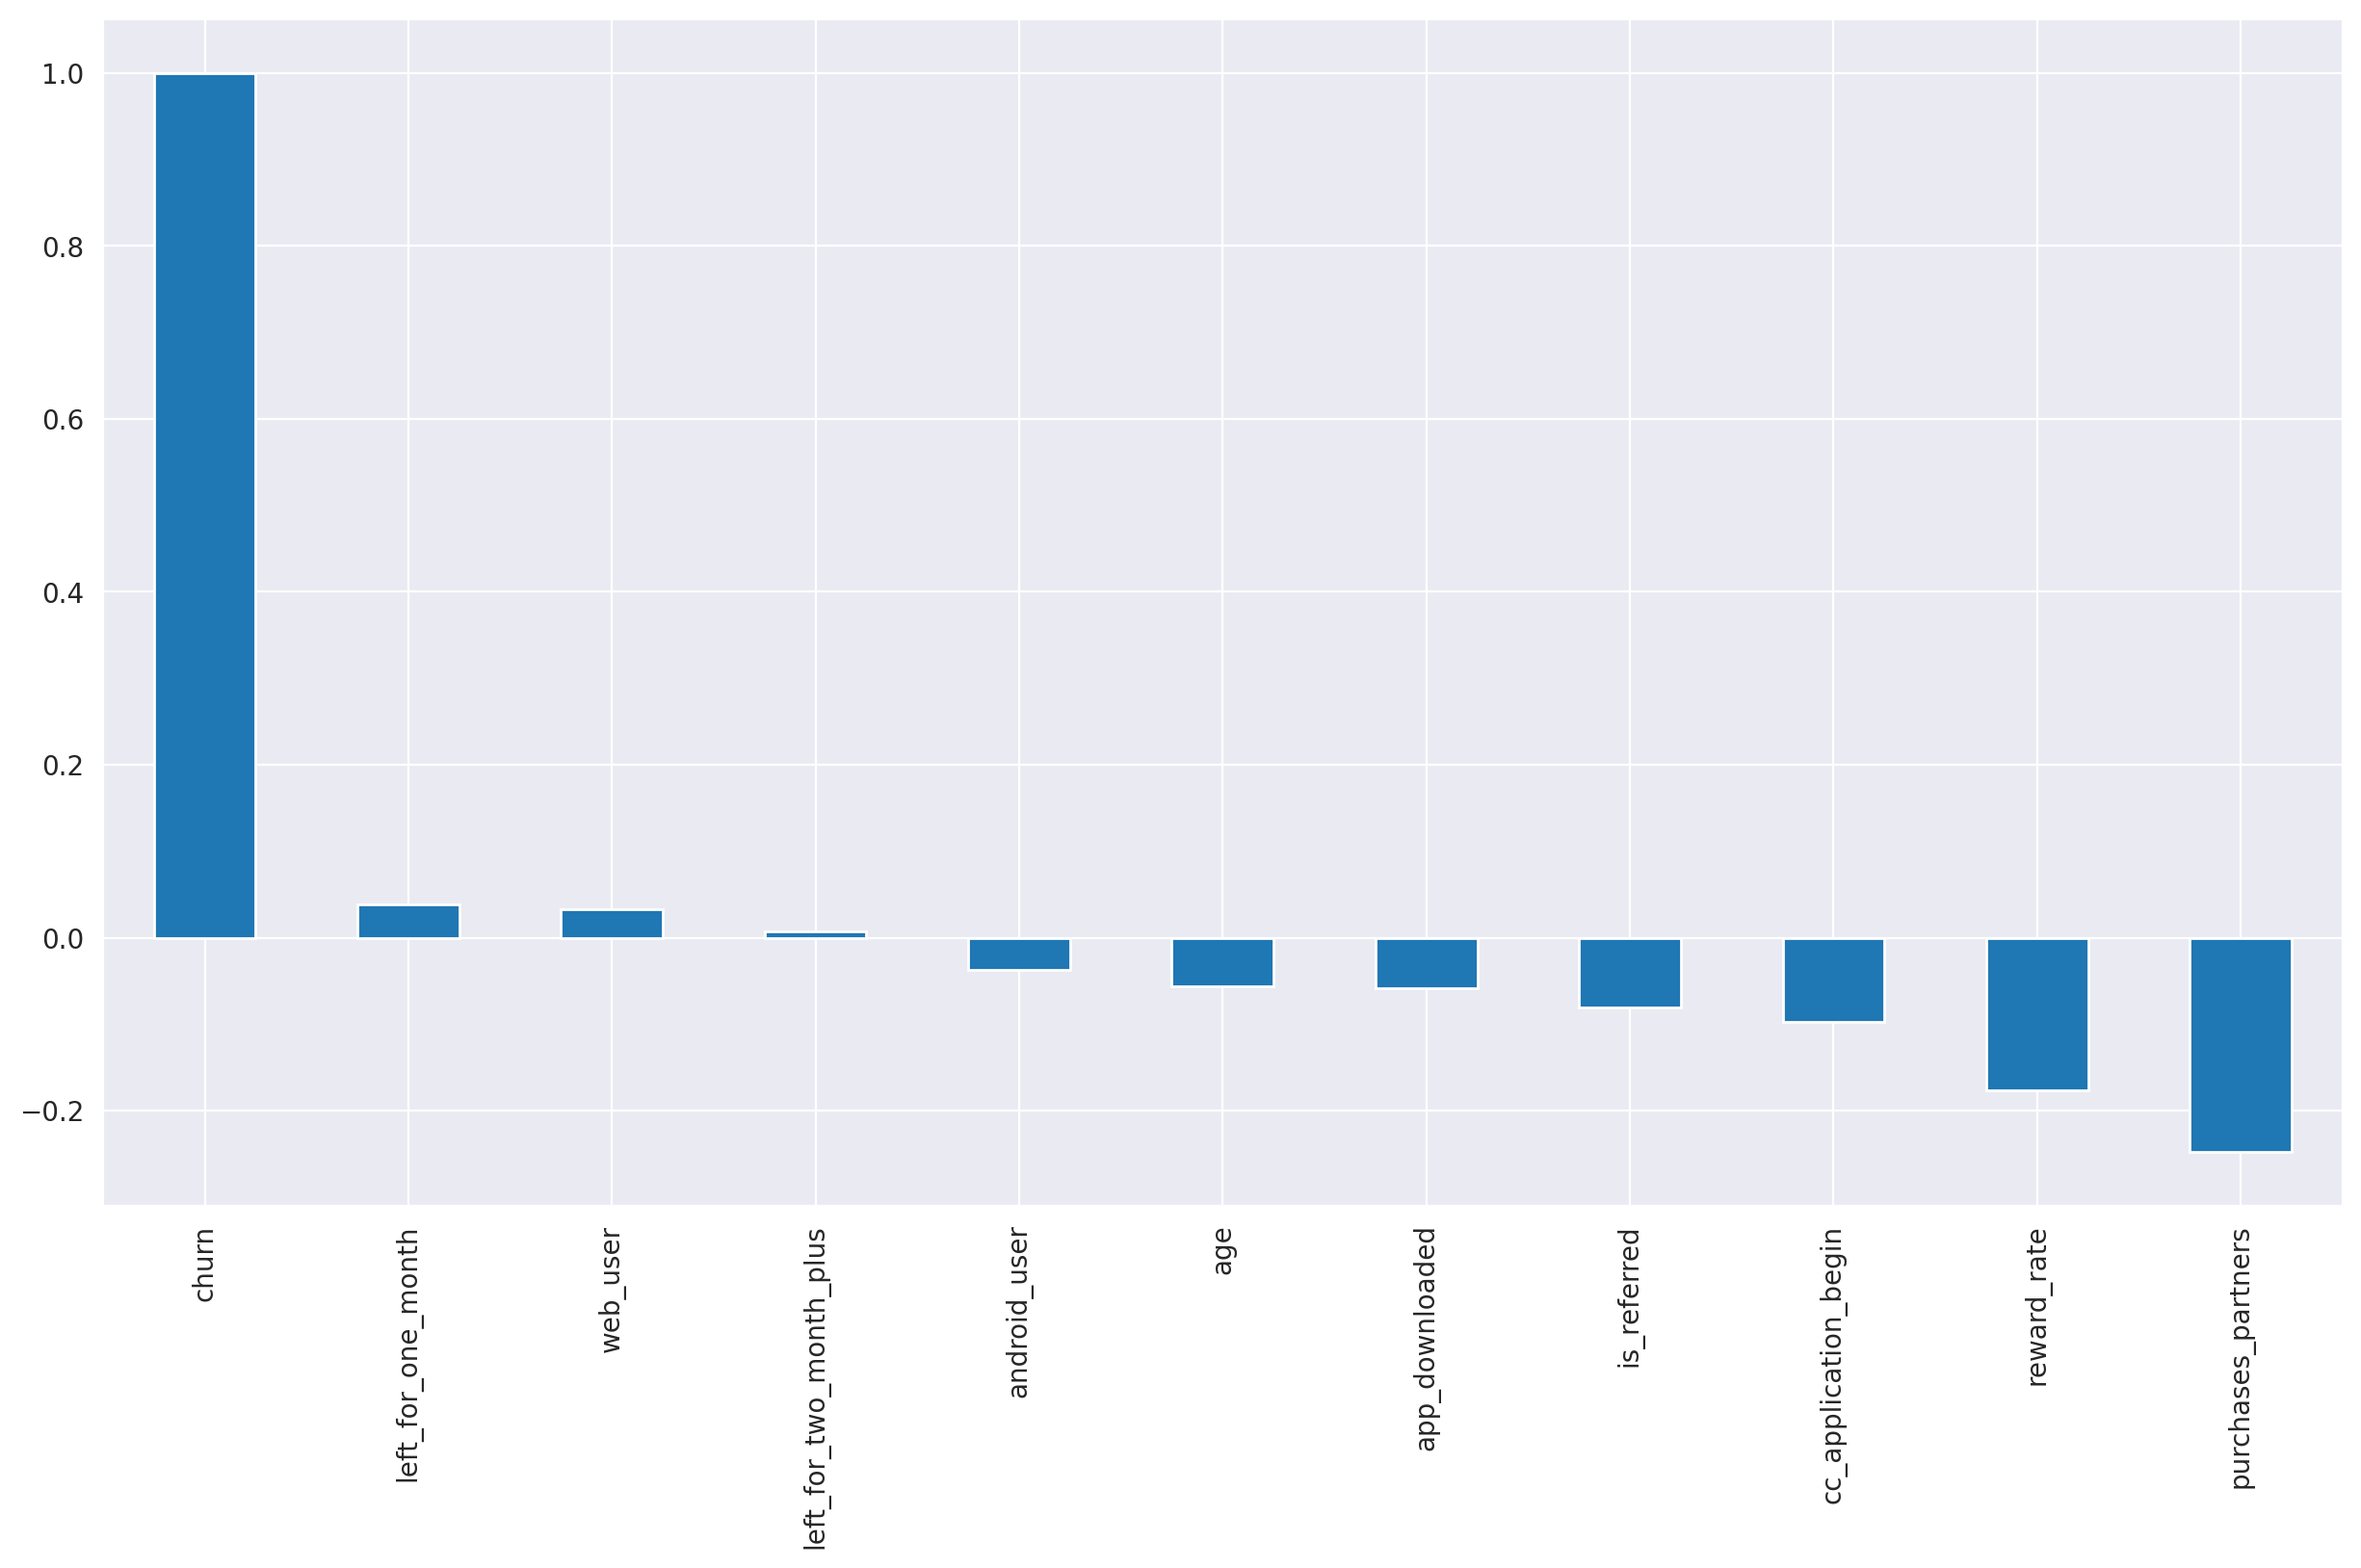

In [35]:
plt.figure(figsize=(15,8))
df[num_features].corr()['churn'].sort_values(ascending = False).plot(kind='bar')

## 6. Create pre-processing pipeline

In [36]:
print("\nSteps for pre-processing: ")
for step, function in enumerate(pipeline_preprocess):
    print("\t {:d}: {:s}".format(step, function.__name__))


Steps for pre-processing: 
	 0: dropnull
	 1: dropduplicated
	 2: dropcolumns
	 3: remove_outlier


In [ ]:
# Definition of preprocess_data for an specific dataset:

def preprocess_data_pipeline(df, pipeline_preprocess):
    for step, function in enumerate(pipeline_preprocess):
        df = function(df)
    print("Size of the dataset:  %d" % df.shape[0])
    print("Number of variables: %d" % df.shape[1])
    df.head(10)
    return df

Testing the preprocess_data_pipeline function for new data:

In [ ]:
df_aux = pd.read_csv('../projectChurnRate/Data/churn_data.csv', index_col=0).sample(n=2100, random_state=0)
preprocess_data_pipeline(df_aux, pipeline_preprocess)

Removing columns credit_score and rewards_earned ...(1)
Drop null values from age column ...(2)
There are duplicated indexes....So removing duplicated indexes ...(3)
Drop app_web_user, deposit, ios_user, cc_recommended, cancelled_loan', 'received_loan', 'rejected_loan', 'waiting_4_loan' columns ...(4)
The outliers are : ['age', 'purchases_partners', 'cc_application_begin', 'reward_rate']
Removing outliers ...(5)
Size of the dataset:  2086
Number of variables: 14


,churn,age,housing,purchases_partners,cc_application_begin,app_downloaded,web_user,android_user,payment_type,zodiac_sign,left_for_two_month_plus,left_for_one_month,reward_rate,is_referred
user,,,,,,,,,,,,,,
50488,0,20.0,R,29,8,1,0,1,Bi-Weekly,Virgo,0,0,0.44,1
53603,0,38.0,na,28,5,1,0,1,Monthly,Sagittarius,0,0,0.67,1
42289,1,40.0,R,9,4,1,1,1,na,Aries,0,0,0.63,1
4185,0,34.0,na,0,4,1,1,0,Bi-Weekly,Scorpio,0,0,2.07,0
12436,1,24.0,O,38,7,1,1,1,Weekly,Scorpio,0,0,0.73,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23350,1,22.0,R,31,7,1,1,1,Weekly,Virgo,1,0,0.00,1
53737,0,43.0,na,23,1,1,1,0,Bi-Weekly,Gemini,0,0,0.50,0
56724,1,40.0,R,0,0,1,1,0,Monthly,Taurus,0,0,0.30,0


In [ ]:
df.to_csv('./Data/df_preprocess_done.csv')
df_pred.to_csv('./Data/df_prediction.csv')